In [1]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch.nn as nn
import numpy as np
import torch
class AutoRegressive(nn.Module):
  def __init__(self, input_size):
    super(AutoRegressive,self).__init__()
    self.input_size = input_size
    self.probability_list = nn.ModuleList().to('cuda')
    self.sigmoid = torch.nn.Sigmoid().to('cuda')



    self.classifiers0 = nn.ModuleList().to('cuda').extend([ nn.Sequential(
        nn.Linear(1,32)
        ,
        nn.ReLU()
        ,
        nn.Linear(32,2)
        ).to('cuda')
,

        nn.Sequential(
        nn.Linear(1,32)
        ,
        nn.ReLU()
        ,
        nn.Linear(32,2)
        ).to('cuda')
,
        nn.Sequential(
        nn.Linear(1,32)
        ,
        nn.ReLU()
        ,
        nn.Linear(32,2)
        ).to('cuda')
    ]
    )

    self.probability_list.append(self.classifiers0)


    for i in range(1 , self.input_size + 1):
      classifiers2 =  nn.ModuleList().to('cuda').extend([
          nn.Sequential(
          nn.Linear(i,32)
          ,
          nn.ReLU()
          ,
          nn.Linear(32,2)
          ).to('cuda')
  ,

          nn.Sequential(
          nn.Linear(i,32)
          ,
          nn.ReLU()
          ,
          nn.Linear(32,2)
          ).to('cuda')
  ,
          nn.Sequential(
          nn.Linear(i,32)
          ,
          nn.ReLU()
          ,
          nn.Linear(32,2)
          ).to('cuda')
          ] )
      self.probability_list.append(classifiers2)

  def forward(self, X):
    batch_size = X.shape[0]
    seq_length = X.shape[1]  # Should be 784 for MNIST (28x28)
    middle_mean = torch.zeros(batch_size,seq_length , 3).to(X.device)
    middle_variance = torch.zeros(batch_size, seq_length , 3).to(X.device)


    # Compute probabilities sequentially
    for i in range(seq_length):
        # Get the i-th probability module (assuming probability_list has seq_length elements)
        prob_module = self.probability_list[i]

        # Use all previous pixels (X[:, :i]) as input
        # Need to reshape to (batch_size, i) since linear layers expect 2D input
        prev_pixels = X[:, :i] if i > 0 else X[:,:1].to(X.device)

        # Compute probability for current pixel
        for mixture_component in range(3):

          predicted_parameters = prob_module[mixture_component](prev_pixels)
          middle_mean[:, i ,mixture_component ] , middle_variance[:, i , mixture_component] = predicted_parameters[: , 0] , self.sigmoid(predicted_parameters[: , 1])
        # teta = prob_module(prev_pixels)

        # Store the probability
        # middle_mean[:, i] = mean.squeeze(-1)
        # middle_variance[:, i] = variance.squeeze(-1)



    # log_probs = X * torch.log(middle_output) + (1 - X) * torch.log(1 - middle_output)
    gussian_loss = 0
    for component in range(3):
      temp = X - middle_mean[:,:,component]
      gussian_loss = gussian_loss + torch.div(torch.mul(temp , temp) , middle_variance[:,:,component])
    # output = torch.sum(log_probs, dim=1)
    output =  torch.sum(gussian_loss, dim=1)

    return torch.sum(output)






In [3]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform to normalize the data
# transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
transform = transforms.Compose([ transforms.ToTensor()])

# Download and load the training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=15000, shuffle=True)



In [ ]:
Autoregressive_model = AutoRegressive(28*28).to('cuda')
optimizer = torch.optim.Adam(Autoregressive_model.parameters(), lr=0.001)
epochs = 25
for epoch in range(epochs):
  print('epoch:',epoch)
  train_loss = 0
  Autoregressive_model.train()
  for batch in train_loader:
    optimizer.zero_grad()
    X, y = batch
    X = X.view(X.shape[0], -1)
    X = X.to('cuda')
    y = y.to('cuda')
    output = Autoregressive_model(X)
    loss = output
    train_loss = train_loss + loss
    loss.backward()
    optimizer.step()
  print('loss:',train_loss/len(train_loader))



epoch: 0
loss: tensor(10199425., device='cuda:0', grad_fn=<DivBackward0>)
epoch: 1


In [ ]:
import matplotlib.pyplot as plt
def visualize_samples(samples, nrows=4, ncols=4):
    """
    Visualize generated samples in a grid
    samples: tensor of shape (num_samples, 1, 28, 28)
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    samples = samples.squeeze().detach().cpu().numpy()  # remove channel dim and convert to numpy

    for i, ax in enumerate(axes.flat):
        if i < len(samples):
            ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
from torch.distributions import Normal
import random
def get_sample(model , sample_number):
  model.eval()
  with torch.no_grad():
    samples = torch.zeros(sample_number,28*28).to('cuda')
    for i in range(sample_number):
      k = random.randint(0,2)
      x0 = torch.rand(1).to('cuda')
      predicted_values = model.probability_list[0][k](x0)
      previous = Normal(predicted_values[0] , torch.sigmoid(predicted_values[1]) ).sample()

      samples[i,0] = previous
      for j in range(28*28):
        if j == 0:
          continue
        previous = samples[i,:j]
        k = random.randint(0,2)
        predicted_values = model.probability_list[j][k](previous)
        samples[i,j] = Normal(predicted_values[0] , torch.sigmoid(predicted_values[1]) ).sample()
    # samples =  torch.bernoulli(samples)
    return samples.view(sample_number, 1, 28, 28)




In [ ]:
samples = get_sample(Autoregressive_model,10)
visualize_samples(samples)

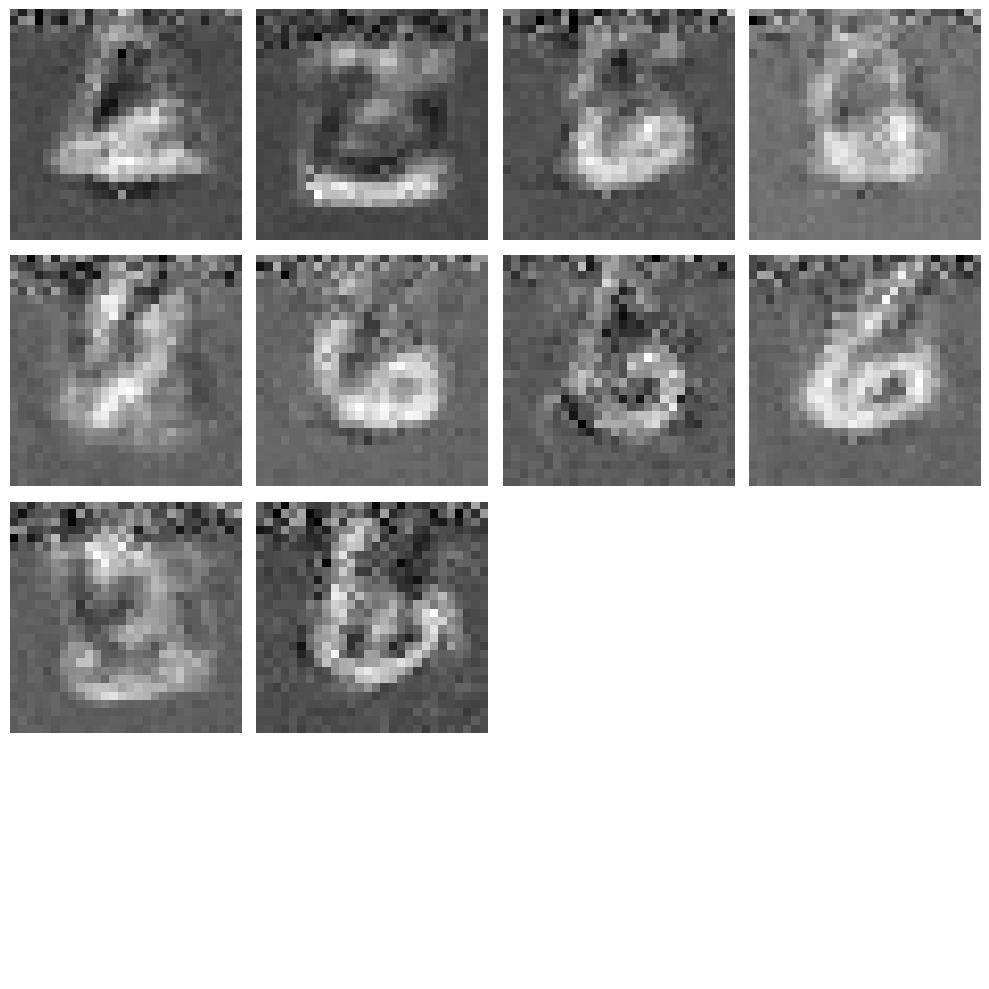

In [13]:
samples = get_sample(Autoregressive_model,10)
visualize_samples(samples)